In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [110]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
GALARY = '/tigress/jiaxuanl/public_html/galary'

In [52]:
from paper_figure import quenched_frac

In [212]:
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 34.347375488830636


% of contaminants in the sample: 11.44 +- 2.20


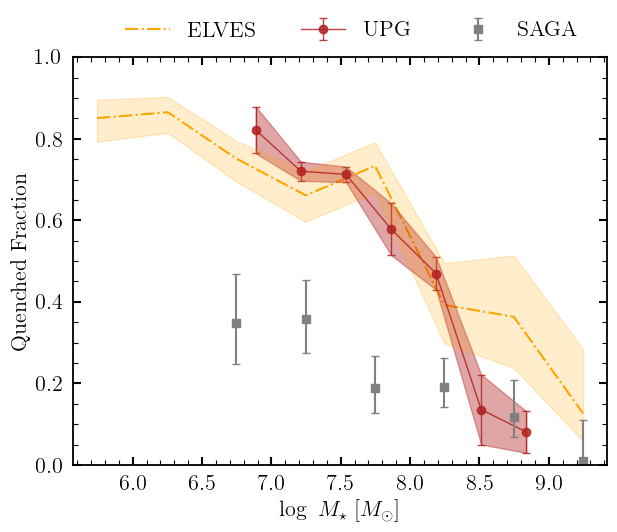

In [219]:
quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              name=name.upper(),
              flag=None, linecolor='firebrick', ax=None, plot_ref=True)

plt.legend(ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20


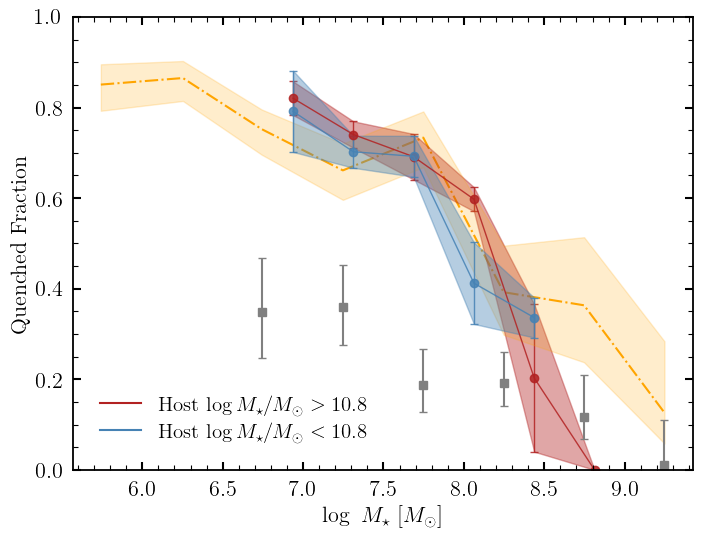

In [215]:
thresh = 10.8

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                        min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                        flag=(udg_cat['host_stellar_mass'] > thresh), 
                        linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_stellar_mass'] <= thresh), linecolor='steelblue', ax=ax, plot_ref=False)


# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))
# ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='firebrick', label=r'Host $\log M_\star / M_\odot > 10.8$')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Host $\log M_\star / M_\odot < 10.8$')

plt.legend(handles=[k_line, b_line], 
           fontsize=15, 
           loc='lower left',
#            bbox_to_anchor=(0., 1.0, 1.3, .0)
          )

In [216]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20


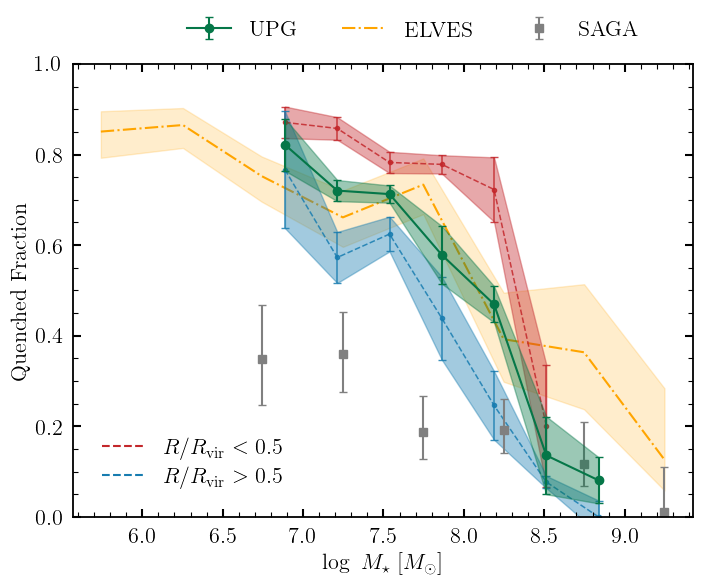

In [218]:
thresh = 0.5

fig, ax = plt.subplots(figsize=(8, 6))

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              name='UPG',
              flag=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5,
                        ax=ax, plot_ref=True)


fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio <= thresh), linecolor='#c3272b', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio > thresh), linecolor='#177cb0', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, loc='upper center', bbox_to_anchor=(0.3, 0.66, 0.5, 0.5))
ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{thresh}$')

plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
          )

In [124]:
import pickle
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in udg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


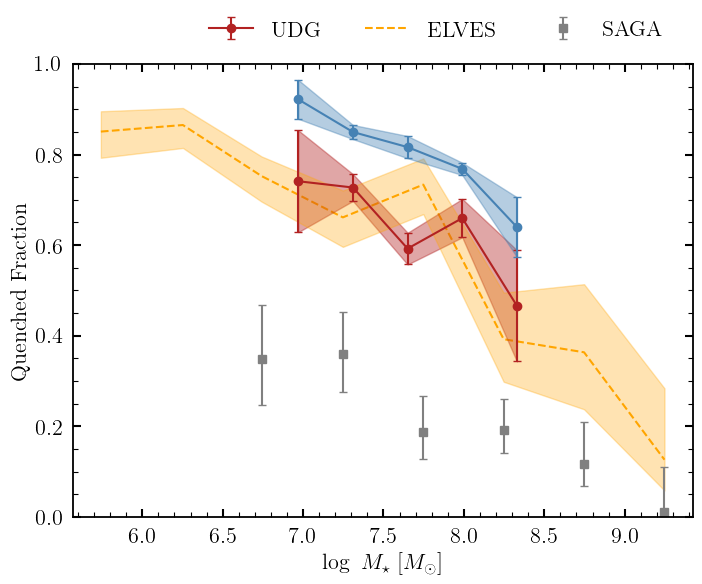

In [125]:
thresh = 1.2

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


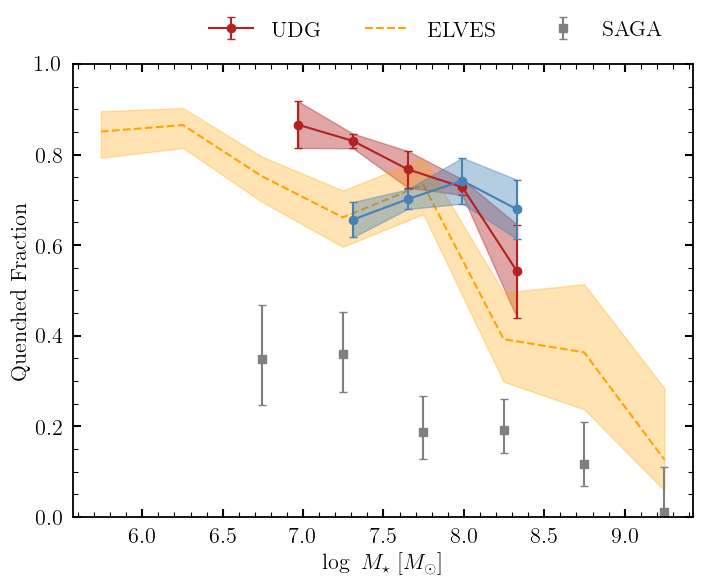

In [127]:
thresh = 0.035

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

---

### Big figure

In [240]:
import matplotlib.lines as mlines

In [277]:
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')

In [291]:
name = 'upg'
thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

In [292]:
import pickle
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in udg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

In [293]:
udg_cat['host_gi'] = host_gi

In [281]:
name = 'udg'
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits', overwrite=True)

In [294]:
name = 'upg'
udg_cat.write(f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits', overwrite=True)

Total angular area [deg2]: 42.019436392194145
% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96
Total angular area [deg2]: 34.347375488830636
% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20


Text(0, 0.5, '')

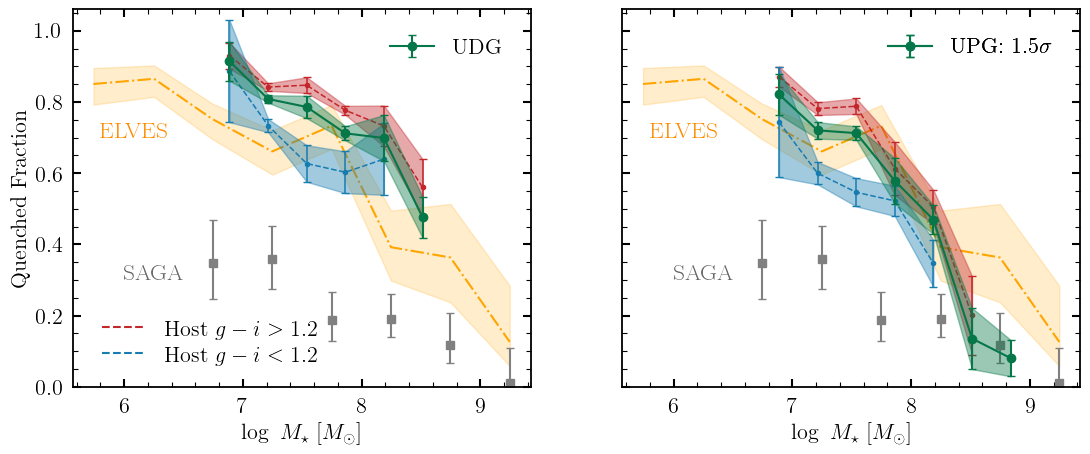

In [305]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220711.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220711_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac.pdf', 
#             bbox_inches='tight', dpi=50)

Total angular area [deg2]: 42.019436392194145
% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96
Total angular area [deg2]: 34.347375488830636
% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20
% of contaminants in the sample: 11.44 +- 2.20


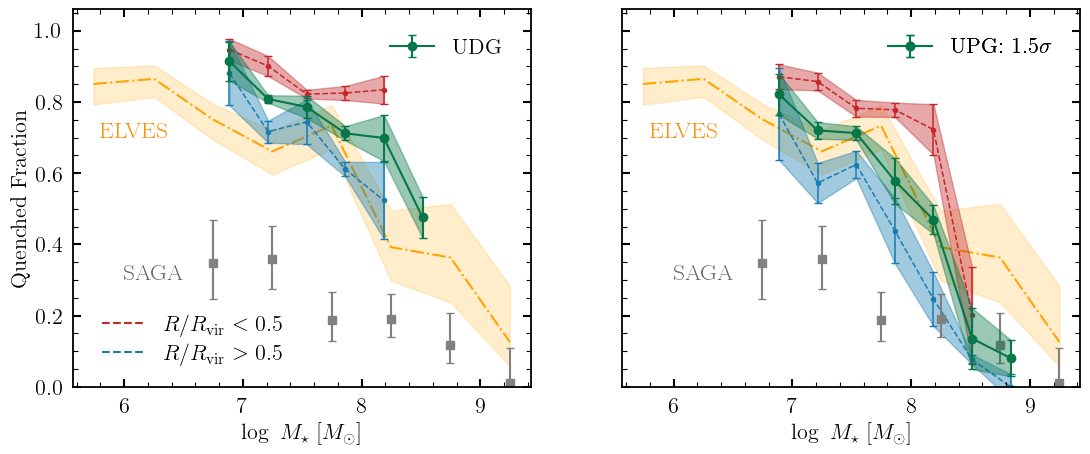

In [302]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220711.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220711_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')


plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac.pdf', 
            bbox_inches='tight', dpi=50)

(0.0, 1.16)

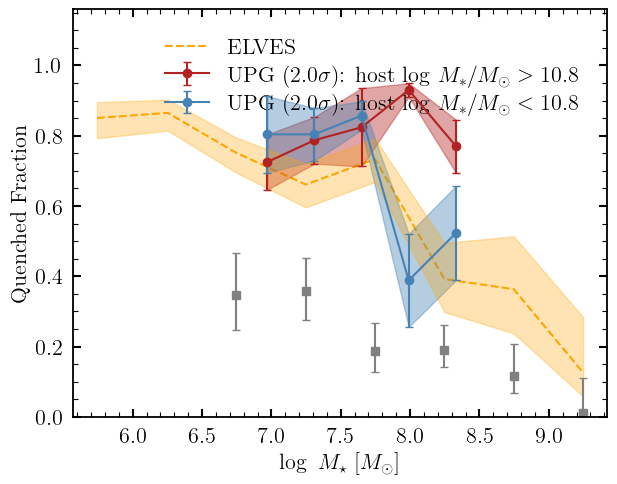

In [70]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(upg_cat['host_stellar_mass'] > 10.8), 
                          (upg_cat['host_stellar_mass'] < 10.8)]):
    y1, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            upg_cat['log_m_star'][flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    sign = '>' if i == 0 else '<'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=f'UPG (2.0$\sigma$): host $\log\, M_*/M_\odot {sign} 10.8$',
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]#[1,0,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

(array([14., 10., 10., 12.,  9., 20., 21., 18., 17., 12.]),
 array([10.21525034, 10.31211666, 10.40898299, 10.50584931, 10.60271563,
        10.69958195, 10.79644827, 10.89331459, 10.99018092, 11.08704724,
        11.18391356]),
 <BarContainer object of 10 artists>)

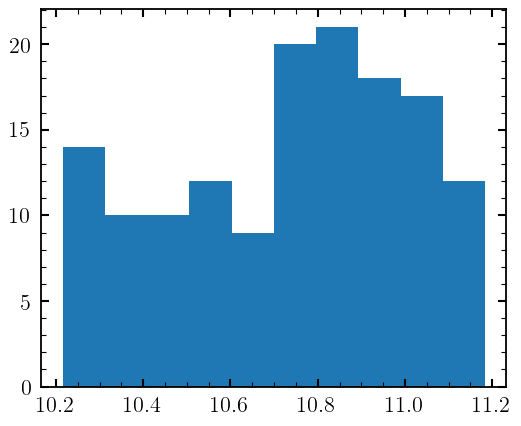

In [71]:
plt.hist(upg_cat['host_stellar_mass'])

#### Morphology

(0.0, 1.16)

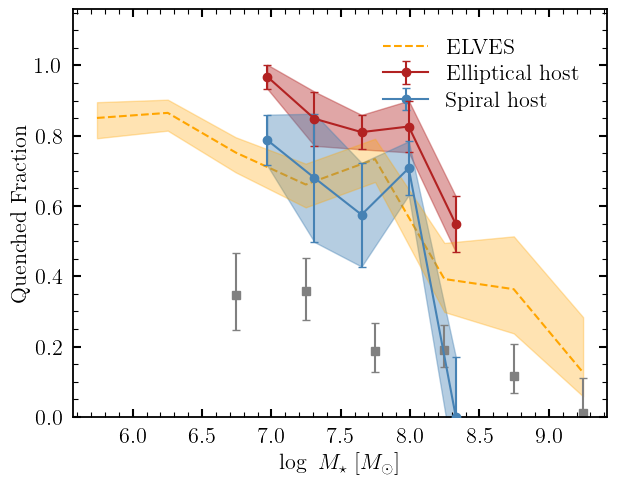

In [30]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(upg_cat['host_elliptical'] == 1), 
                          (upg_cat['host_spiral'] == 1)]):
    y1, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            upg_cat['log_m_star'][flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = 'Elliptical host' if i == 0 else 'Spiral host'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

In [72]:
import pickle

In [73]:
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)

In [74]:
host_gi = []
for name in upg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)

In [75]:
host_gi = np.array(host_gi)

(0.0, 1.16)

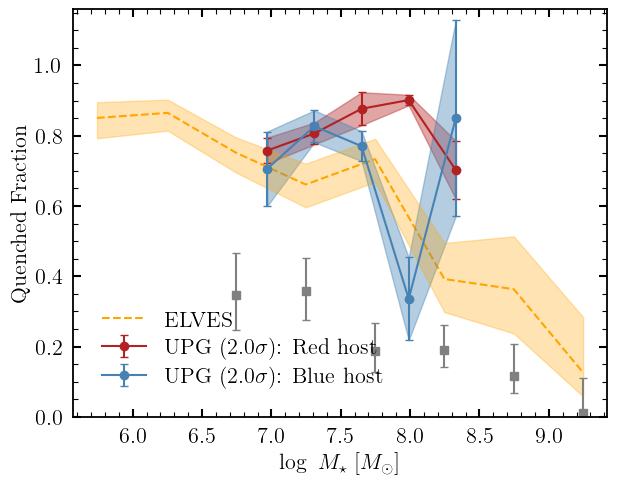

In [76]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(host_gi > 1.2), 
                          (host_gi < 1.2)]):
    y1, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            upg_cat['log_m_star'][flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = 'UPG (2.0$\sigma$): Red host' if i == 0 else 'UPG (2.0$\sigma$): Blue host'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)

avg comp: 0.20107399786559876
avg comp: 0.24359045767036644
avg comp: 0.32080582252260437
avg comp: 0.44770596312432326
avg comp: 0.6193847687118752
avg comp: 0.5963463089995926


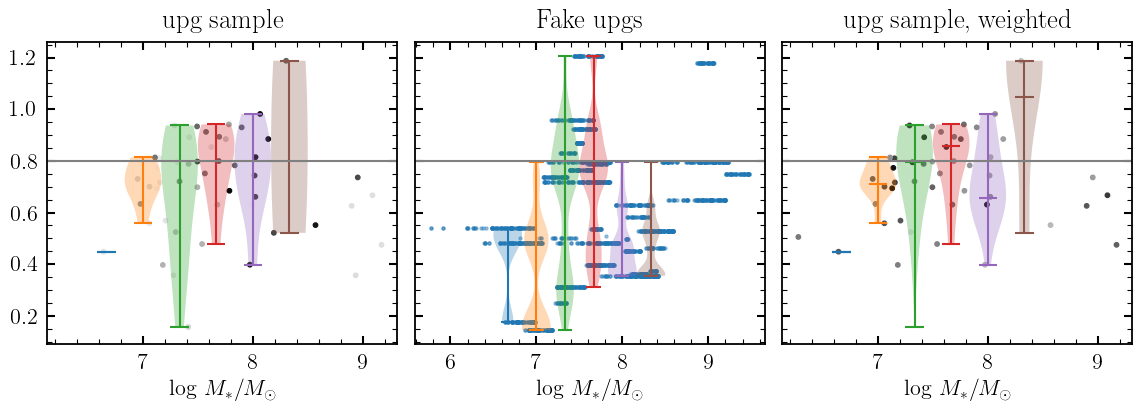

In [82]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

flag = (host_gi < 1.2)
plt.sca(ax1)
res = binned_statistic(upg_cat[flag]['log_m_star'].data, upg_cat[flag]['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        plt.violinplot(upg_cat[flag][res.binnumber == i+1]['g-i'].data, 
                       widths=np.diff(cen)[0],
                       positions=[cen[i]])
    except:
        pass
plt.scatter(upg_cat[flag]['log_m_star'], upg_cat[flag]['g-i'], c=upg_cat[flag]['completeness'], cmap='Greys', zorder=0, s=10)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('upg sample')

plt.sca(ax2)
res = binned_statistic(fake_upg_cat['log_m_star'].data, fake_upg_cat['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        plt.violinplot(fake_upg_cat[res.binnumber == i+1]['g-i'].data, 
                       widths=np.diff(cen)[0],
                       positions=[cen[i]])
    except:
        pass

plt.scatter(fake_upg_cat['log_m_star'], fake_upg_cat['g-i'], zorder=0, s=5, alpha=0.4)
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('Fake upgs')


plt.sca(ax3)
res = binned_statistic(upg_cat[flag]['log_m_star'].data, upg_cat[flag]['log_m_star'].data, range=(6.5, 8.5), bins=6)
cen = 0.5 * (res.bin_edges[1:] + res.bin_edges[:-1])
for i in range(6):
    try:
        print('avg comp:', np.mean(upg_cat[flag][res.binnumber == i+1]['completeness'].data))
        vpstats1 = custom_violin_stats(upg_cat[flag][res.binnumber == i+1]['g-i'].data, 
                                       weights2[flag][res.binnumber == i+1])
        ax3.violin(vpstats1, widths=np.diff(cen)[0],
                   positions=[cen[i]], vert=True, showextrema=True,
                   showmedians=True)
    except Exception as e:
        print(e)
        pass
    
plt.scatter(upg_cat[flag]['log_m_star'], upg_cat[flag]['g-i'], c=np.log10(weights2[flag]), 
#             vmax=1, 
            zorder=0, s=10, cmap='Greys')
plt.axhline(0.8, color='gray')
plt.xlabel(r'$\log\, M_*/M_\odot$')
plt.title('upg sample, weighted')


plt.subplots_adjust(wspace=0.05)

---
### Radial distance bins ###

In [83]:
upg_coord = SkyCoord(upg_cat['ra'], upg_cat['dec'], unit='deg')
host_coord = SkyCoord(upg_cat['host_RA'], upg_cat['host_DEC'], unit='deg')
dist = upg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / upg_cat['host_r_vir_ang'].data

(0.0, 1.16)

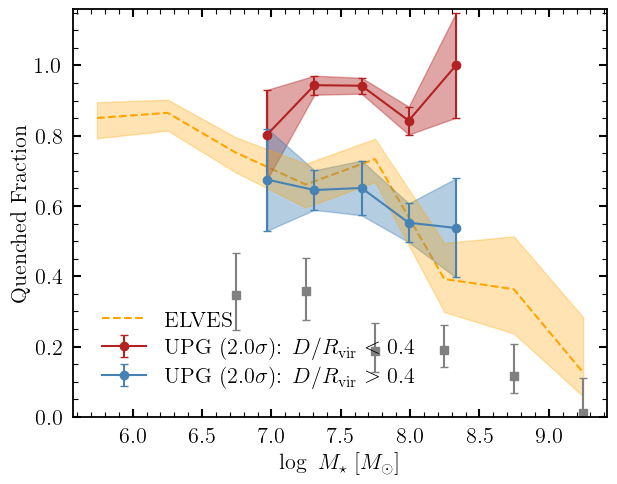

In [85]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

for i, flag in enumerate([(dist_ratio < 0.4), 
                          (dist_ratio >= 0.4)]):
    y1, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            red[flag].astype(float) * weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    y2, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            weights2[flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='sum', range_=(6.8, 8.5), bins=5, n_slide=20)

    num, cens = moving_binned_statistic(upg_cat['log_m_star'][flag],
                            upg_cat['log_m_star'][flag],  
                            x_err=upg_cat['log_m_star_err'][flag],
                            statistic='count', range_=(6.8, 8.5), bins=5, n_slide=20)
    num = np.median(num, axis=0)

    quench_frac = np.median(y1 / y2, axis=0)
    quench_frac_std = np.sqrt(quench_frac * (1 - quench_frac) / num) 
    quench_frac_std = np.std(y1 / y2, axis=0)
    
    label = r'UPG (2.0$\sigma$): $D/R_{\rm vir} < 0.4$' if i == 0 else r'UPG (2.0$\sigma$): $D/R_{\rm vir} > 0.4$'
    color = 'firebrick' if i == 0 else 'steelblue'
    plt.errorbar(cens, 
                 quench_frac, 
                 yerr=quench_frac_std, fmt='o-', 
                 label=label,
                 color=color, zorder=10)

    plt.fill_between(cens, 
                     quench_frac - quench_frac_std, 
                     quench_frac + quench_frac_std, 
                     color=color, alpha=0.4)


plt.plot(elves_confirmed_q[:, 0], elves_confirmed_q[:, 1], 
         color='orange', label='ELVES', ls='--', zorder=0)
plt.fill_between(elves_confirmed_q[:, 0], 
                 elves_confirmed_q_upper[:, 1], 
                 elves_confirmed_q_lower[:, 1], 
                 color='orange', 
                 alpha=0.3)

plt.errorbar(saga_q[:, 0], saga_q[:, 1], 
             yerr=[-saga_q_err[:, 0], saga_q_err[:, 1]], fmt='s', 
             color='grey',
             label='SAGA')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction') #  ($g - i > 0.8$)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#            loc='lower left'
#            bbox_to_anchor=(0.5, 0.66, 0.5, 0.5)
          )
plt.ylim(0, 1.16)